In [1]:
!gpustat

c08d5f53f934             Sat May 11 13:22:27 2024  535.129.03
[0] Tesla P100-PCIE-16GB | 31°C,   0 % |   107 / 16384 MB |


In [2]:
!nvidia-smi

Sat May 11 13:22:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from platform import python_version
print("Python version", python_version())

Python version 3.10.13


Data uploading: google drive/wget

In [4]:
import torch
import numpy as np
import random
import torchaudio
import librosa

import torch.nn as nn
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision.transforms as transforms

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau,ExponentialLR, CosineAnnealingLR
import torch.nn.init as init
from torch.optim import Adam

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)  # If using CUDA
torch.cuda.manual_seed_all(0)  # For all GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False #Disable optimizations that may lead to non-deterministic behavior

In [5]:
def load_spectrograms(filepath):
    """Load spectrograms from a numpy .npy file."""
    return np.load(filepath)

# Load train and test spectrograms
test_spectrograms = load_spectrograms('/kaggle/input/human-spec/human2_test_spectrograms.npy')
train_spectrograms = load_spectrograms('/kaggle/input/human-spec/human_train_spectrograms.npy')

print("Train Spectrograms:", train_spectrograms.shape, train_spectrograms.dtype)
print("Test Spectrograms:", test_spectrograms.shape, test_spectrograms.dtype)

Train Spectrograms: (11886, 128, 259) float32
Test Spectrograms: (2447, 128, 259) float32


In [6]:
# Load labels
import numpy as np

def load_labels(filename):
    with open(filename, 'r') as file:
        labels = [int(line.strip()) for line in file.readlines()]
    return labels

labels = load_labels('/kaggle/input/spectrogram-and-label-t/train_label.txt')


In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# Reshape spectrograms to include a channel dimension 
train_spectrograms_reshaped = np.expand_dims(train_spectrograms, axis=1)  # Adds a new axis at position 1
test_spectrograms_reshaped = np.expand_dims(test_spectrograms, axis=1)

train_spectrograms = train_spectrograms.reshape((-1, 1, 128, 259))  # -1 tells numpy to calculate the necessary size to maintain the same number of elements
test_spectrograms = test_spectrograms.reshape((-1, 1, 128, 259))

print(train_spectrograms_reshaped.shape)
print(test_spectrograms_reshaped.shape)


(11886, 1, 128, 259)
(2447, 1, 128, 259)


In [9]:
#Data Normalization：mean-variance is better than max-min
def standardize_spectrograms(spectrograms):
    """ Standardize spectrograms to have zero mean and unit variance. """
    standardized = []
    for spec in spectrograms:
        mean = np.mean(spec)
        std = np.std(spec)
        if std > 0:
            standardized.append((spec - mean) / std)
        else:
            standardized.append(spec)  # Handle zero variance scenarios
    return np.array(standardized)

train_spectrograms = standardize_spectrograms(train_spectrograms)
test_spectrograms = standardize_spectrograms(test_spectrograms)

In [10]:
#Data Augmentation

class SpectrogramTransform:
    """Applies spectrogram transformations for data augmentation.""" #50 20 小于 27 13 小于 40 15 大于 45 18
    def __init__(self, add_reversal = True, max_temporal_mask_size=50, max_frequency_mask_size=20, use_time_warp=True, W=5, sample_rate=44100): 
        self.add_reversal = add_reversal
        self.sample_rate = sample_rate
        self.max_temporal_mask_size = min(max_temporal_mask_size, 128)  # Ensure mask size doesn't exceed spectrogram size
        self.max_frequency_mask_size = min(max_frequency_mask_size, 268)
        self.augmentations = nn.Sequential(
            T.FrequencyMasking(freq_mask_param=self.max_frequency_mask_size),
            T.TimeMasking(time_mask_param=self.max_temporal_mask_size)
        )
        self.use_time_warp = use_time_warp
        self.W = W  

    def reverse_spectrogram(self, spectrogram):
        """Reverse the spectrogram."""
        if self.add_reversal and random.random() > 0.5:  # Apply reversal randomly
            return spectrogram.flip(dims=[-1])
        return spectrogram
    
    def time_warp(self, spectrogram, W=5):
        if not self.use_time_warp or spectrogram.shape[2] <= 2 * W:
            return spectrogram

        device=spectrogram.device
        spectrogram = spectrogram.clone()  # Clone the spectrogram tensor to ensure not modifying the original tensor
        time_length = spectrogram.shape[2]

        # Randomly choose a time warp point
        pt = torch.randint(W, time_length - W, (1,), device=device)

        # Randomly decide the shifting factor
        src = pt.item()
        dest = src + torch.randint(-W, W, (1,), device=device).item()

        # Correct the indices if they go out of bounds
        if dest < 0:
            dest = 0
        elif dest >= time_length:
            dest = time_length - 1

        # Apply time warping
        if dest > src:
            shifted_portion = spectrogram[:, :, src+1:dest+1].clone()
            spectrogram[:, :, src:dest] = shifted_portion
        elif src > dest:
            shifted_portion = spectrogram[:, :, dest:src].clone()
            spectrogram[:, :, dest+1:src+1] = shifted_portion

        return spectrogram

    def __call__(self, spectrogram):
        spectrogram = self.time_warp(spectrogram)
        spectrogram = self.reverse_spectrogram(spectrogram)
        spectrogram = self.augmentations(spectrogram)
        return spectrogram

# Define a custom Dataset class
class AudioDataset(Dataset):
    def __init__(self, spectrograms, labels, transform=None):
        self.spectrograms = spectrograms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        spectrogram = self.spectrograms[idx]
        label = self.labels[idx]
        
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32) if not isinstance(spectrogram, torch.Tensor) else spectrogram
        label = torch.tensor(label, dtype=torch.long) if not isinstance(label, torch.Tensor) else label
        
        # Apply data augmentation if transform is provided
        if self.transform:
            spectrogram = self.transform(spectrogram)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        return spectrogram, label
    
def mixup_data(x, y, alpha=0.4, device='cuda'):
    '''Compute the mixup data. Pass lambda to the mixup criterion.'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
        
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)  # Ensure index tensor is on the correct device

    mixed_x = lam * x + (1 - lam) * x[index, :]  # Mix images
    y_a, y_b = y, y[index]  # Get corresponding mixed labels

    return mixed_x, y_a, y_b, lam

train_spectrograms_t = torch.tensor(train_spectrograms, dtype=torch.float32)  # Ensure it's a tensor
labels = torch.tensor(labels, dtype=torch.long)

#split first before augmentation!!
dataset = TensorDataset(train_spectrograms_t, labels) #train dataset without augmentation

train_spectrograms_t = torch.tensor(train_spectrograms_t, dtype=torch.float32)  # Ensure it's a tensor
labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are also tensors and use appropriate dtype

# Split dataset into training and validation sets
total_samples = len(dataset)
num_val = 2400  # Number of validation samples
num_train = total_samples - num_val  # Remaining samples for training
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

# Calculate class weights after splitting
def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    class_proportion = class_counts / len(labels)
    class_weights =  1./ class_proportion
    return torch.FloatTensor(class_weights)

# Extract labels from train_dataset correctly
train_labels = [dataset[idx][1].item() for idx in train_dataset.indices]
class_weights = calculate_class_weights(np.array(train_labels))
print("Class weights:", class_weights)

#any random operation within your data loading process is reproducible across different run
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# Create instance of SpectrogramTransform
audio_transform = SpectrogramTransform()
train_dataset_augmented = AudioDataset(train_dataset[:][0], train_dataset[:][1], transform=audio_transform)
train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn, generator=g) #

# Create DataLoader without augmentation for validation
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=4, worker_init_fn=worker_init_fn)

/tmp/ipykernel_34/1382844090.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_spectrograms_t = torch.tensor(train_spectrograms_t, dtype=torch.float32)  # Ensure it's a tensor
/tmp/ipykernel_34/1382844090.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are also tensors and use appropriate dtype


Class weights: tensor([11.4565,  3.8250,  3.4696,  2.7544])


In [14]:
#14 layer cnn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, 1)
        self.softmax = nn.Softmax(dim=-1)  # Softmax over each row

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)
        attention = self.softmax(energy)
        value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return out + x  # Skip connection
    
class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.res_block1 = ResidualBlock(64)
        self.res_block2 = ResidualBlock(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.res_block3 = ResidualBlock(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.res_block4 = ResidualBlock(256)

        # Adding a new convolutional layer
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3,3), stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.res_block5 = ResidualBlock(512)
        
        #self.self_attention = SelfAttention(512) 
        #self.fc1 = nn.Linear(65536, 1024) 
        
        self.fc1 = nn.Linear(512 * 8 * 16, 1024)  # Adjust the dimensions based on the output of the last pooling layer
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.res_block3(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.res_block4(x)

        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.res_block5(x)
        
        #x = self.self_attention(x) 
        #print(x.shape) 

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [16]:
import time

class LSR2(nn.Module):
    def __init__(self, class_weights=None, e=0.01, reduction='mean'):
        super(LSR2, self).__init__()
        self.class_weights = class_weights
        self.e = e
        self.reduction = reduction
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, target):
        if x.size(0) != target.size(0):
            raise ValueError("Expected input batchsize to match target batchsize")

        logprobs = self.log_softmax(x)
        target_smooth = F.one_hot(target, num_classes=x.size(1)) * (1 - self.e) + (self.e / x.size(1))
        
        if self.class_weights is not None:
            loss = -torch.sum(self.class_weights * target_smooth * logprobs, dim=1)
        else:
            loss = -torch.sum(target_smooth * logprobs, dim=1)

        if self.reduction == 'none':
            return loss
        elif self.reduction == 'sum':
            return torch.sum(loss)
        elif self.reduction == 'mean':
            return torch.mean(loss)
        else:
            raise ValueError("Unsupported reduction: {}".format(self.reduction))

# Initialize the model
model = SpectrogramCNN()
model.to(device)

# Calculate class weights inversely proportional to class frequencies
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = LSR2(class_weights=class_weights_tensor, e=0.1, reduction='mean')
#criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

scheduler = CosineAnnealingLR(optimizer, T_max=3, eta_min=0.000001, verbose = True)#1e-6
#scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


/tmp/ipykernel_34/1513940419.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


In [17]:
print("Spectrograms shape:", train_spectrograms.shape)
print("Labels shape:", labels.shape)

Spectrograms shape: (11886, 1, 128, 259)
Labels shape: torch.Size([11886])


In [18]:
#Mixup version
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(loader, model, criterion, device):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, label in loader:
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(label.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            loss = criterion(outputs, label)
            loss_sum += loss.item()
            
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    average_loss = loss_sum / len(loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    return accuracy, average_loss, f1, precision, recall    

# Training and evaluation loop
train_accuracies = []
val_accuracies = []
train_loss_t, val_loss_t = [],[]
best_accuracy = 0
best_loss = 100
n_epoch = 30
alpha = 0.4  # MixUp hyperparameter

for epoch in range(n_epoch):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Apply MixUp
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=alpha, device=device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Calculate MixUp loss
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct = lam * (predicted == targets_a).sum().float() + (1 - lam) * (predicted == targets_b).sum().float()
        train_correct += correct.item()
        train_total += labels.size(0)
        train_loss += loss.item()
    
    train_accuracy = train_correct / train_total
    train_loss_avg = train_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_loss_t.append(train_loss_avg)

    print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss_avg:.4f}')

    # Evaluate on the validation set
    val_accuracy, val_loss, val_f1, val_precision, val_recall = evaluate_model(val_loader, model, criterion, device)
    val_accuracies.append(val_accuracy)
    val_loss_t.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')

    scheduler.step() #exponential, cosine
    #scheduler.step(val_loss)  # Reduce learning rate based on the validation loss
    
    # Implement logic for saving the best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_loss.pth')
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model_acc.pth')

Epoch 1, Train Accuracy: 0.5495, Train Loss: 4.3986
Epoch 1, Val Accuracy: 0.7383, Val Loss: 3.3771, Val F1: 0.7698, Precision: 0.7840, Recall: 0.7773
Adjusting learning rate of group 0 to 7.5025e-04.
Epoch 2, Train Accuracy: 0.6645, Train Loss: 3.8821
Epoch 2, Val Accuracy: 0.5858, Val Loss: 4.6668, Val F1: 0.5677, Precision: 0.7092, Recall: 0.7023
Adjusting learning rate of group 0 to 2.5075e-04.
Epoch 3, Train Accuracy: 0.6947, Train Loss: 3.7064
Epoch 3, Val Accuracy: 0.6875, Val Loss: 3.4778, Val F1: 0.6909, Precision: 0.7380, Recall: 0.7707
Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 4, Train Accuracy: 0.7047, Train Loss: 3.6598
Epoch 4, Val Accuracy: 0.7925, Val Loss: 2.9427, Val F1: 0.8101, Precision: 0.8047, Recall: 0.8387
Adjusting learning rate of group 0 to 2.5075e-04.
Epoch 5, Train Accuracy: 0.7209, Train Loss: 3.5734
Epoch 5, Val Accuracy: 0.8196, Val Loss: 2.8342, Val F1: 0.8359, Precision: 0.8277, Recall: 0.8537
Adjusting learning rate of group 0 to 7.5025e

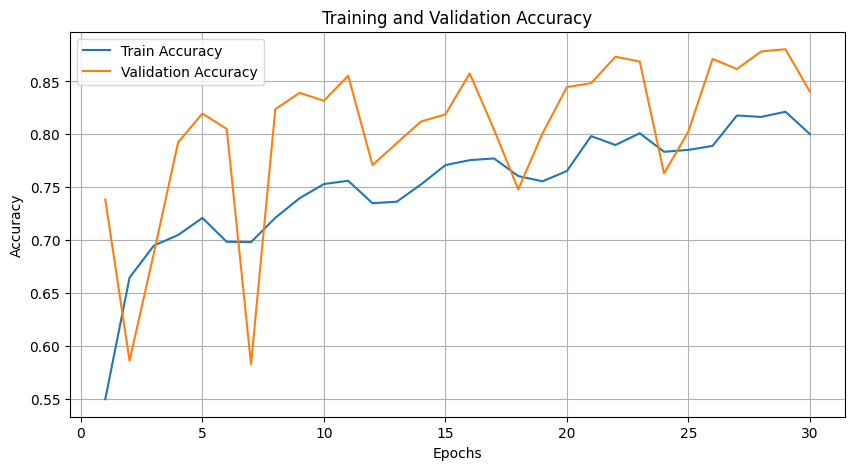

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epoch+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epoch+1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

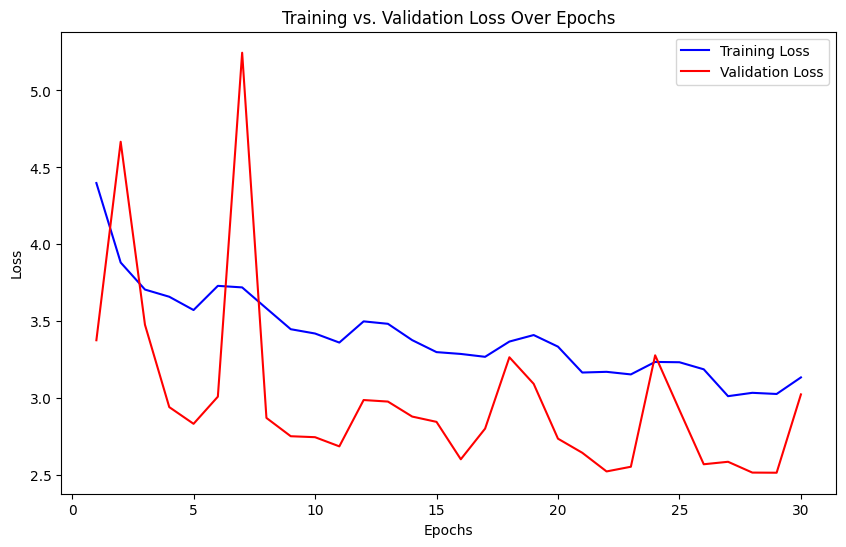

In [20]:
import matplotlib.pyplot as plt

epochs = range(1,n_epoch+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_t, 'b', label='Training Loss')
plt.plot(epochs, val_loss_t, 'r', label='Validation Loss')

# Adding title and labels
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding legend
plt.legend()

# Display the plot
plt.show()


In [21]:
test_spectrograms = torch.tensor(test_spectrograms, dtype=torch.float32)
test_dataset = TensorDataset(test_spectrograms)  # No labels available
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_samples = len(test_dataset)

predictions = []

best_model = SpectrogramCNN()
best_model.load_state_dict(torch.load('best_model_acc.pth'))# Load the best model parameters
best_model.to(device)

best_model.eval()
best_model.to(device)
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        inputs = inputs.unsqueeze(0)
        outputs = best_model(inputs[0])
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

import pandas as pd
test_ids = np.arange(0, test_samples)

# Convert predictions and ids into a DataFrame
submission_df = pd.DataFrame({'id': test_ids, 'category': predictions})

# Save the DataFrame to a CSV file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

In [22]:
print(test_dataset[0])

(tensor([[[-2.5959, -2.5959, -2.4793,  ..., -1.6535, -1.1609, -0.6217],
         [-2.5959, -2.5959, -2.5959,  ..., -1.9111, -1.4894, -0.6144],
         [-2.5959, -2.5959, -2.5735,  ..., -1.6940, -1.2415, -0.5205],
         ...,
         [-1.7959, -0.3205,  0.3677,  ..., -0.1565, -0.0231, -0.0469],
         [-2.1949, -0.4098,  0.2829,  ..., -0.0525,  0.0901, -0.0074],
         [-1.9951, -0.4368,  0.2379,  ...,  0.2026,  0.1768,  0.0064]]]),)
